# Binary Classifier Performance Evaluation

## Binary Classification Data

A tiny example:

In [1]:
using Random

function logitgen(intercept::Real, slope::Real, len::Int; seed = 888)
    Random.seed!(seed)
    x = 10 .* rand(len)                     # random uniform [0, 10)
    sort!(x)                                # x ascending
    logit = @. intercept + slope * x        # logit(prob) = ln(p / (1 + p)) = linear equation
    prob = @. 1. / (1. + exp(-logit))       # probability scale
    y = rand(len) .<= prob
    x, y
end

x, y = logitgen(-3., 0.5, 1_000)
sum(y), length(y)

(416, 1000)

## DataFrame

In [2]:
using DataFrames

bcdata = DataFrame(target = y, x = x)
Base.summarysize(bcdata)

8840

## Logistic Regression

In [3]:
using GLM

m = glm(@formula(target ~ x), bcdata, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

target ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────────
              Estimate  Std. Error   z value  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  -3.43294    0.21388    -16.0508    <1e-57  -3.85214   -3.01375
x             0.589421   0.0358702   16.432     <1e-59   0.519117   0.659726
────────────────────────────────────────────────────────────────────────────

In [4]:
typeof(m)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

In [5]:
Base.summarysize(m)

106472

Note the model object has a copy of the input data as well as other vectors such as residuals, it is bigger than the original input data.

In [6]:
coef(m)

2-element Array{Float64,1}:
 -3.4329419184580563
  0.5894213367960294

In [7]:
bcdata.pred = predict(m)
sum(bcdata.pred)

416.0000042804553

## ROC

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

In [8]:
using ROC            # https://github.com/diegozea/ROC.jl

In [9]:
bcroc = roc(bcdata.pred, bcdata.target)
typeof(bcroc)

ROCData{Infinity.InfExtendedReal{Float64}}

In [10]:
AUC(bcroc)

0.8601529570600573

┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::ROCData{Infinity.InfExtendedReal{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Daymond\.julia\packages\Plots\XbAWb\src\pipeline.jl:15
┌ Warning: Attribute alias `xlim` detected in the user recipe defined for the signature (::ROCData{Infinity.InfExtendedReal{Float64}}). To ensure expected behavior it is recommended to use the default attribute `xlims`.
└ @ Plots C:\Users\Daymond\.julia\packages\Plots\XbAWb\src\pipeline.jl:15
┌ Warning: Attribute alias `ylab` detected in the user recipe defined for the signature (::ROCData{Infinity.InfExtendedReal{Float64}}). To ensure expected behavior it is recommended to use the default attribute `yguide`.
└ @ Plots C:\Users\Daymond\.julia\packages\Plots\XbAWb\src\pipeline.jl:15
┌ Warning: Attribute alias `ylim` detected in the user recipe defined for the signature (::ROCData{Infinity.In

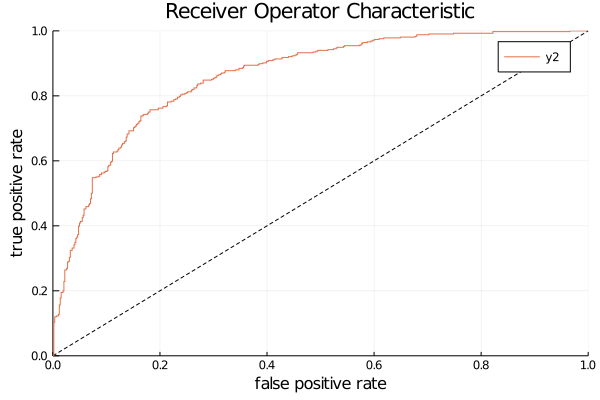

In [11]:
using Plots

plot(bcroc)

┌ Warning: Attribute alias `color` detected in the user recipe defined for the signature (::ROCData{Infinity.InfExtendedReal{Float64}}). To ensure expected behavior it is recommended to use the default attribute `seriescolor`.
└ @ Plots C:\Users\Daymond\.julia\packages\Plots\XbAWb\src\pipeline.jl:15
┌ Warning: Attribute alias `xlim` detected in the user recipe defined for the signature (::ROCData{Infinity.InfExtendedReal{Float64}}). To ensure expected behavior it is recommended to use the default attribute `xlims`.
└ @ Plots C:\Users\Daymond\.julia\packages\Plots\XbAWb\src\pipeline.jl:15
┌ Warning: Attribute alias `ylab` detected in the user recipe defined for the signature (::ROCData{Infinity.InfExtendedReal{Float64}}). To ensure expected behavior it is recommended to use the default attribute `yguide`.
└ @ Plots C:\Users\Daymond\.julia\packages\Plots\XbAWb\src\pipeline.jl:15
┌ Warning: Attribute alias `ylim` detected in the user recipe defined for the signature (::ROCData{Infinity.In

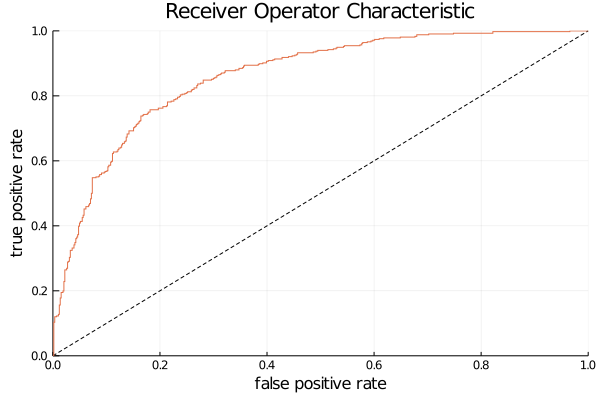

In [12]:
plot(bcroc, legend = nothing)

## Two Sample Kolmogorov Smirnov Test

https://juliastats.org/HypothesisTests.jl/stable/

In [13]:
p1 = bcdata.pred[bcdata.target]
p0 = bcdata.pred[.!bcdata.target]

using HypothesisTests

ks = ApproximateTwoSampleKSTest(p1, p0)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.5757046891464712

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-69

Details:
    number of observations:   [416,584]
    KS-statistic:              8.973313804987665


In [14]:
ks.δ

0.5757046891464712

In [15]:
dump(ks)

ApproximateTwoSampleKSTest
  n_x: Int64 416
  n_y: Int64 584
  δ: Float64 0.5757046891464712
  δp: Float64 0.0017123287671216014
  δn: Float64 0.5757046891464712


This is about what we can achieve today in Julia's ecosystem.
If this was a copy/paste course, we'll stop here.

# Improvements

## ROC graph recipe revised

In [16]:
# Plots recipe

@recipe function dummy(roc::ROCData)
    xlims := (0, 1)
    ylims := (0, 1)
    xguide := "False Positive Rate"
    yguide := "True Positive Rate"
    legend := :bottomright
    aspect_ratio := :equal
    title --> "AUC is $(round(AUC(roc), digits = 4))"

    @series begin
        seriescolor --> :blue
        linewidth --> 1.2
        label := "Model"
        roc.FPR, roc.TPR
    end

    @series begin
        seriescolor --> :black
        linewidth --> 0.3
        linestyle --> :dash
        label := "Random"
        [0, 1], [0, 1]
    end
end

Once the plot recipe is defined, we can simply plot the ROCData:

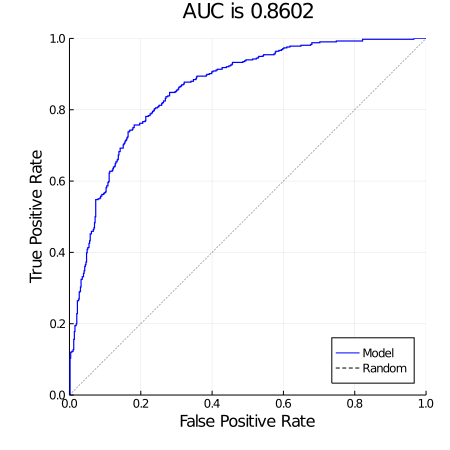

In [17]:
plot(bcroc, size = (450, 450))

This is the preferred approach as you define the plot recipe once and can plot many ROC curves easily.

## Equivalent via Plot

This is for illustrative purposes to show what you need to do otherwise.

In [18]:
function rocplot(roc::ROCData)
    plt = plot(size = (450, 450), aspect_ratio = :equal, xlims = (0, 1), ylims = (0, 1), legend = :bottomright)
    plot!(roc.FPR, roc.TPR, label = "Model", seriescolor = :blue, lw = 1.2)
    plot!([0., 1.], [0., 1.], label = "Random", seriescolor = :black, lw = 0.3, linestyle = :dash)
    title!("AUC is $(round(AUC(roc), digits = 4))")
    xlabel!("False Positive Rate")
    ylabel!("True Positive Rate")
    plt
end

rocplot (generic function with 1 method)

Always create functions.  
Don't copy/paste code to run in global scope.

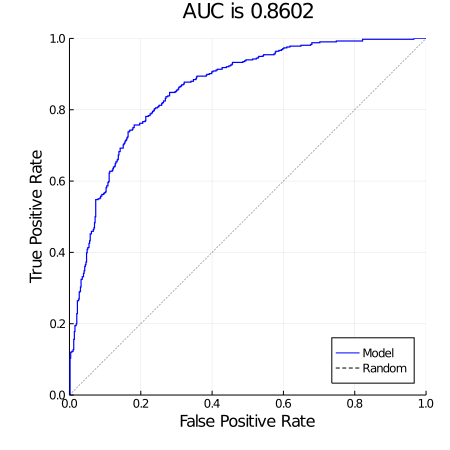

In [19]:
rocplot(bcroc)

## Empirical CDF Graph

StatsBase has a function **ecdf** that will calculate the empirical cumulative distribution function.
We can use it to draw the two sample KS graph which is a plot of the two cumulative distributions.

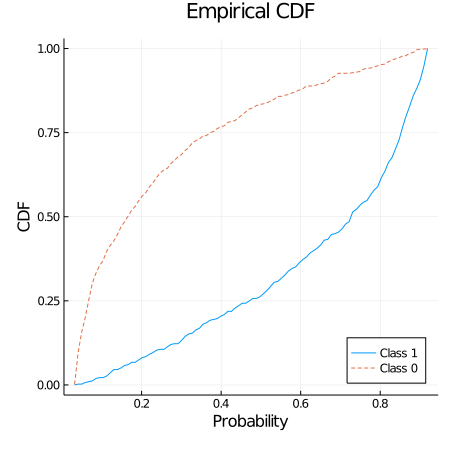

In [20]:
using StatsBase

probrng = range(minimum(bcdata.pred), maximum(bcdata.pred); length = 100)    # [min prob, max prob] 100 values

p1cdf = ecdf(p1)            # create function that will evaluate CDF
p0cdf = ecdf(p0)            # create function that will evaluate CDF

plot(size = (450, 450), aspect_ratio = :none, legend = :bottomright)
plot!(probrng, p1cdf(probrng), label = "Class 1")
plot!(probrng, p0cdf(probrng), label = "Class 0", linestyle = :dash)
title!("Empirical CDF")
xlabel!("Probability")
ylabel!("CDF")

Class 1 is shifted towards higher probability (right side).

## KS Graph

It is more useful to plot, by descending probability, % of class 1 captured and % of class 0 captured.  
This means we should plot the tail of the CDF, and we should flip the x axis to go from high probability to low probability:

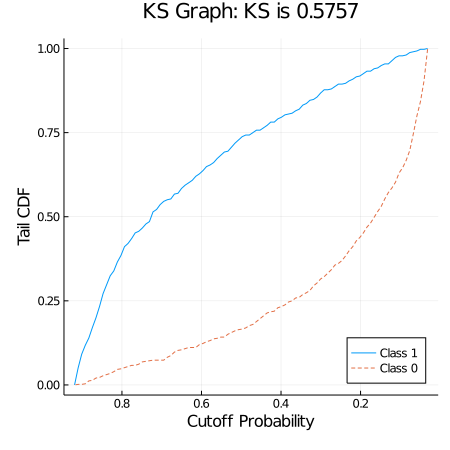

In [21]:
plot(size = (450, 450), aspect_ratio = :none, legend = :bottomright)
plot!(probrng, 1. .- p1cdf(probrng), label = "Class 1", xflip = :true)
plot!(probrng, 1. .- p0cdf(probrng), label = "Class 0", xflip = :true, linestyle = :dash)
title!("KS Graph: KS is $(round(ks.δ, digits = 4))")
xlabel!("Cutoff Probability")
ylabel!("Tail CDF")

This is a correct graph on a descending probability scale.

## Even Better KS Graph?

What's the bounding box for the perfect model?
Well, if the model is perfect we will have perfect separation, the beginning of the sorted file are all class 1, and at some point it is all class 0.

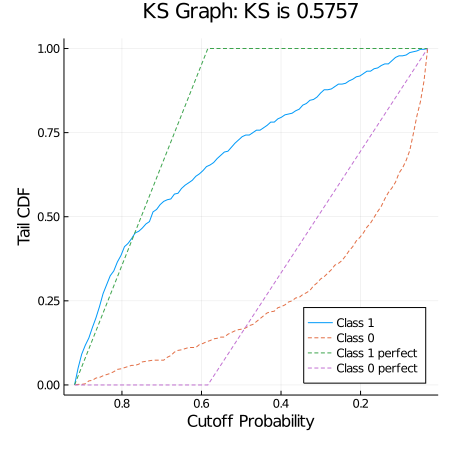

In [22]:
baserate = ks.n_x / (ks.n_x + ks.n_y)
predcdf = ecdf(bcdata.pred)

plot(size = (450, 450), aspect_ratio = :none, legend = :bottomright)
plot!(probrng, 1. .- p1cdf(probrng), label = "Class 1", xflip = :true)
plot!(probrng, 1. .- p0cdf(probrng), label = "Class 0", xflip = :true, linestyle = :dash)
plot!([maximum(probrng), 1. - ks.n_x / (ks.n_x + ks.n_y), minimum(probrng)], [0., 1., 1.],
    label = "Class 1 perfect", xflip = :true, linestyle = :dash)
plot!([maximum(probrng), 1. - ks.n_x / (ks.n_x + ks.n_y), minimum(probrng)], [0., 0., 1.],
    label = "Class 0 perfect", xflip = :true, linestyle = :dash)
title!("KS Graph: KS is $(round(ks.δ, digits = 4))")
xlabel!("Cutoff Probability")
ylabel!("Tail CDF")

Hmmm, doesn't look right.
Why are the actuals outside the presumed bounding box?
What's going on?

## KS Graph from scratch

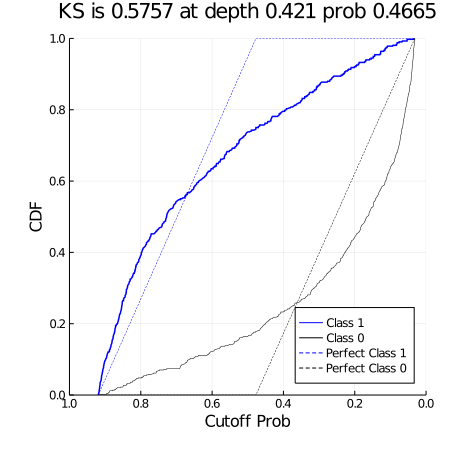

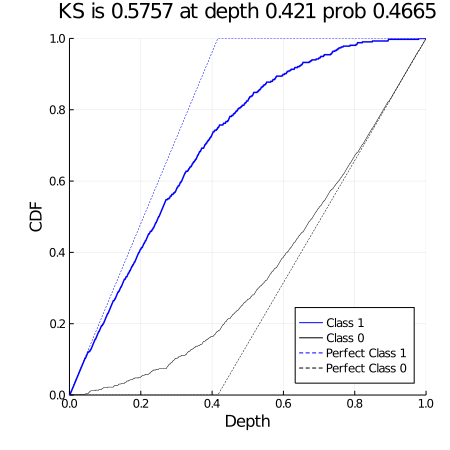

0.5757046891464699
Max separation is 0.5757 at depth 0.421 prob 0.467


In [23]:
function ksplot(target, pred)
    ix = sortperm(pred, rev = true)       # index of sort descending prob
    tgt = target[ix]                      # re-arrange
    prb = pred[ix]                        # re-arrange
    
    n = length(tgt)                       # num obs
    n1 = sum(tgt)                         # num class 1
    n0 = n - n1                           # num class 0
    baserate = n1 / n                     # base rate
    
    depth = (1:n) ./ n                    # cutoff depth
    cdf1 = cumsum(tgt) ./ n1              
    cdf0 = cumsum(.!tgt) ./ n0
    sep = cdf1 .- cdf0                    # separation between class 1 and 0
    
    maxsep = maximum(sep)                 # max separation value
    argsep = argmax(sep)                  # max separation position
    
    println("$maxsep")
    println("Max separation is $(round(maxsep, digits = 4)) at depth $(round(depth[argsep], digits = 3)) prob $(round(prb[argsep], digits = 3))")

    #--- Plots

    plt1 = plot(size = (450, 450), aspect_ratio = :equal,
        xlims = (0., 1.), ylims = (0., 1.), legend = :bottomright)
    plot!(depth, cdf1, label = "Class 1", width = 1.5, seriescolor = :blue)
    plot!(depth, cdf0, label = "Class 0", width = 0.5, seriescolor = :black)
    xlabel!("Depth")
    ylabel!("CDF")
    title!("KS is $(round(maxsep, digits = 4)) at depth $(round(depth[argsep], digits = 3)) prob $(round(prb[argsep], digits = 4))")

    plot!([0., baserate, 1.], [0., 1., 1.], label = "Perfect Class 1", width = 0.5, seriescolor = :blue, linestyle = :dash)
    plot!([0., baserate, 1.], [0., 0., 1.], label = "Perfect Class 0", width = 0.5, seriescolor = :black, linestyle = :dash)
    
    #---
    
    plt2 = plot(size = (450, 450), aspect_ratio = :equal,
        xlims = (0., 1.), ylims = (0., 1.), legend = :bottomright)
    plot!(prb, cdf1, label = "Class 1", xflip = true, width = 1.5, seriescolor = :blue)
    plot!(prb, cdf0, label = "Class 0", xflip = true, width = 0.5, seriescolor = :black)
    xlabel!("Cutoff Prob")
    ylabel!("CDF")
    title!("KS is $(round(maxsep, digits = 4)) at depth $(round(depth[argsep], digits = 3)) prob $(round(prb[argsep], digits = 4))")

    plot!([prb[1], prb[n1], prb[n]], [0., 1., 1.], label = "Perfect Class 1", xflip = true, width = 0.5, seriescolor = :blue, linestyle = :dash)
    plot!([prb[1], prb[n1], prb[n]], [0., 0., 1.], label = "Perfect Class 0", xflip = true, width = 0.5, seriescolor = :black, linestyle = :dash)

    #---
    
    display(plt2)
    display(plt1)
end

ksplot(bcdata.target, bcdata.pred)

The bounding box works when the X axis is depth, not probability.
It doesn't work on the probability scale because the relationship between depth and probability is nonlinear.
The bounding box on the probability scale is actually a curve.

So, we can figure out a way to keep the graph and relabel the X axis (axis scale would be uneven), or write more code to translate depth to probability and then plot correctly on the probability scale -- another programming challenge to develop skills and waste time.

# Discussion

## Confusion Matrix

Given model prediction and a cuoff threshold, we can construct a confusion matrix:

Confusion Matrix  | Real Positive  |  Real Negative 
-----|-----------|-------------------
**PP (Predict Positive)**  | TP (True Positive)  | FP (False Positive) Type I Error
**PN (Predict Negative)** | FN (False Positive) Type II Error | TN (True Negative)
**N (Total)**      | RP  | RN

RP, RN, N are fixed given a dataset.  
TP, FP, PP; FN, TN, PN depends on model prediction and cut-off threshold used.

0. **Base Rate** is **RP / N**, sometimes called **prevalence**

We can calculate eight proportion from TP, TN, FP, FN as follows.

Denominator is Truth, given you know the real situation:

1. **Sensitivity (TPR)** - when there is a situation, how often does the alarm correctly come on? (sensitive to the situation)

    - is your diagnosis sensitive to the Real Positives? Does the alarm come on when there is a fire?
    - If your instrument doesn't react to Real Positives, if the alarm doesn't come on when there is a fire, it is useless (always off)
    - defined as **TP / RP**, or **TP / (TP + FN)**, proportion of Real Positives captured
    - Also known as **True Positive Rate (TPR), Recall**


2. **False Negative Rate (FNR)** - when there is a situation, how often does the alarm falsely not come on?

    - defined as **FN / RP**, within Real Positives, what proportion are incorrect False Negatives?
    - it is **1 - Sensitivity**
    

3. **Specificity (TNR)** - when there is no situation, does the alarm stay off? (silent when no situation)

    - is your diagnosis specific to the real positives? If your instrument over-reacts and gives positive diagnosis all the time, it is useless (always on)
    - defined as **TN / RN**, proportion of Real Negatives captured
    - Also known as **True Negative Rate**
    

4. **False Positive Rate (FPR)** - when there is no situation, how often does the alarm falsely come on?

    - defined as **FP / RN**, within the Real Negatives, what proportion are incorrect False Positives?
    - it is **1 - Specificity**


A perfect model can achieve 100% Sensitivity and 100% Specificity simultaneously at some threshold.

Denominator is Prediction.
This is perhaps more natural as it reflects the situation where you don't know the truth, you only have a diagnostic:

5. **Precision** - when alarm comes on, how often is it correct?

    - **TP / PP**, within the predictions, how many are true?
    - I call this the **hit rate** or **expected success rate**, you can expect 1 sale every X calls
    

6. When alarm comes on, how often is it wrong?

    - **FP / PP**
    - 1 - Precision
    - wasted effort, cost of doing business, I need to get through all of PP in order to find TP because prediction is not perfect
    

7. When alarm is off, how often is it correct?

    - **TN / PN**
    - correctly avoided expending resource where there is no result
    

8. When alarm is off, how often is it wrong?

    - **FN / PN**
    - missed opportunity due to poor prediction
    

General:

9. **Accuracy** is **(TP + TN) / N**



## Observation

1. The eight proportions are **threshold dependent**, you pick a different threshold, the proportions change
2. They are also **base rate dependent** meaning you can't compare across different problems (datasets)

To be a genuinely useful binary classifier evaluation metric, we need it to be:

- threshold independent (by looking at overall performance over all thresholds)
- base rate independent so that we can compare models of different problems

We can solve \#1, but not \#2.

## ROC

Receiver Operating Characteristics:

- plot of Sensitivity (True Positive Rate) vs. False Positive Rate (1 - Specificity), varying threshold from high to low implicitly (not shown on graph)
- Random model is a diagnonal line
- Perfect model (fully separated)
    - Beginning of file is all Real Positives
        - True Positive Rate increases from 0 to 1
        - False Positive Rate remains at 0
        - ROC curve goes from (0,0) to (0,1) straight up the Y axis
    - After the Real Positives, it is all Real Negatives
        - True Positive Rate remains at 1
        - False Positive Rate increases from 0 to 1
        - ROC curve goes from (0,1) horizontally across to (1,1) 

AUROC or C = Area Under ROC

## Gini

Gini = 2C - 1

= Area of ROC bigger than diagonal line x 2

Gini ranges between \[0, 1\]

## Optimal separation

There are people that look at the ROC curve and ask, what is the best cut-off as the cur-off is implicit on the graph.

There are two school of thought:

- closest to perfect model (upper left corner):  find the point that is closest to the upper left via euclidean distance of corner to curve
- furthest from non-informative:  find largest vertical distance between ROC surve and diagonal line

## KS

I don't like the ROC approaches. I prefer using the KS measure:

- Maximum separation between the CDF of the two classes
- Point that achieves the maximum separation

## Unequal cost benefit

ROC, Gini, KS ascribes the same value to TP, FN, TN, FP.
What if they are valued differently?

## Performance at different threshold

What if you are capacity constrained, e.g., fraud prevention, how many cases are you willing to setup to investigate rare events?
Should you still be looking at ROC, Gini, KS in this situation?

I believe you should look at the ROC/KS only at the capacity depth to pick the winner.
We care only about performance at the very top of the predictions. not overall general performance.

## Manipulating the metrics

We can manipulate ROC, Gini, KS by adding in trivial cases.
For example, an easy way to boost apparent performance of a cross-sell model is to add in a whole bunch of non-responders that have low probability.

We can compare ROC/Gini/KS for a particular dataset across algorithms.
It is difficult to say what is better when the datasets are different.

We are never safe from dataset manipulations.
Always confirm the modelling dataset is constructed appropriately before you invest time and energy building ML/AI models.

# Rank Order Statistics

ROC, Gini, KS depends only on the rank ordering of the predictions, they are measures of separation of the dsitribution of the two classes, they are not measures of accuracy which requires calibration, e.g., multiply probability by 2 does not change ROC, Gini or KS.

The **AUC** function in the ROC package implements numeric integration of the ROC curve. https://github.com/diegozea/ROC.jl/blob/master/src/roc_main.jl  

The trapezoidal area under an empirical ROC curve is equal to the Mann-Whitney two-sample rank measure of association statistic (a generalized U-statistic) applied to two samples as follows:

- Class 1 has N1 observations, Class 0 has N0 observations, total is N = N1 + N0
- Compare the value of each member of one class against the other, i.e., all possible pair-wise comparison of the two classes (think outer-product).
Total number of pairs is N1 x N0.
    - if value of class 1 is > value of class 0, it is **concordant**
    - if the values are (approximately) the same, it is **tied**
    - otherwise it is **discordant**

We then calculate the following:

- **AUC is (concordant + 0.5 tied) / pairs**
- **Gini is (concordant - discordant) / pairs**
- **Gamma is (concordant - discordant) / (concordant + discordant)**
- **Tau is (concordant - discordant) / (0.5 * N * (N - 1))**

Different versions of SAS/STAT used different tolerances to determine tied pairs.
The more recent versions use small tolerances which increased the amount of computation, previously larger tolerances were used which computed faster.

The **roc** function in the ROC package is reasonably fast for <= 1,000 observations.
It slows down tremendously beyond that.
Production quality code is not just about correctness, speed matters if you want to play with big data.

## Brute Force 1

Think like a SQL programmer. Use Cartesian outer-product because that's what the algorithm says, right?

Putting the data into a SQL table and doing cartesian join is a really stupid idea.  Disks are very slow compared to RAM.
Julia data structures are memory resident, so it should be OK, right?

Brute Force 1:  double nested do-loop for outer-product

In [24]:
function auc_dbl_loop(target, pred; eps = 1e-8)
    class1 = pred[target]
    class0 = pred[.!target]
    
    pairs = length(class1) * length(class0)
    conc = 0
    disc = 0
    for c1 in class1
        for c0 in class0
            conc += (c1 >= c0 + eps)
            disc += (c1 <= c0 - eps)
        end
    end
    tied = pairs - conc - disc

    conc, tied, disc, (conc + 0.5 * tied) / pairs
end

auc_dbl_loop (generic function with 1 method)

In [25]:
auc_dbl_loop(bcdata.target, bcdata.pred)

(208969, 0, 33975, 0.8601529570600632)

In [26]:
using BenchmarkTools

@benchmark auc_dbl_loop(bcdata.target, bcdata.pred)

BenchmarkTools.Trial: 
  memory estimate:  8.34 KiB
  allocs estimate:  5
  --------------
  minimum time:     38.099 μs (0.00% GC)
  median time:      38.300 μs (0.00% GC)
  mean time:        40.512 μs (1.20% GC)
  maximum time:     4.926 ms (98.89% GC)
  --------------
  samples:          10000
  evals/sample:     1

## Brute Force 2

Single Loop, use vector operations for inner loop:

In [27]:
function auc_sng_loop(target, pred; eps = 1e-8)
    class1 = pred[target]
    class0 = pred[.!target]
    
    class0U = class0 .+ eps          # pre-compute
    class0L = class0 .- eps          # pre-compute
    
    pairs = length(class1) * length(class0)
    conc = 0
    disc = 0
    for c1 in class1
        conc += sum(c1 .>= class0U)
        disc += sum(c1 .<= class0L)
    end
    tied = pairs - conc - disc

    conc, tied, disc, (conc + 0.5 * tied) / pairs
end

auc_sng_loop (generic function with 1 method)

In [28]:
auc_sng_loop(bcdata.target, bcdata.pred)

(208969, 0, 33975, 0.8601529570600632)

In [29]:
using BenchmarkTools

@benchmark auc_sng_loop(bcdata.target, bcdata.pred)

BenchmarkTools.Trial: 
  memory estimate:  3.57 MiB
  allocs estimate:  2503
  --------------
  minimum time:     484.900 μs (0.00% GC)
  median time:      591.599 μs (0.00% GC)
  mean time:        851.734 μs (23.50% GC)
  maximum time:     6.219 ms (80.92% GC)
  --------------
  samples:          5864
  evals/sample:     1

## Brute Force 3

Use outer product operator instead of looping.

In [30]:
function auc_out_prod(target, pred; eps = 1e-8)
    class1 = pred[target]
    class0 = pred[.!target]
    
    pairs = length(class1) * length(class0)
    conc = sum(class1 .>= (class0 .+ eps)')          # outer product
    disc = sum(class1 .<= (class0 .- eps)')
    tied = pairs - conc - disc

    conc, tied, disc, (conc + 0.5 * tied) / pairs
end

auc_out_prod (generic function with 1 method)

In [31]:
auc_out_prod(bcdata.target, bcdata.pred)

(208969, 0, 33975, 0.8601529570600632)

In [32]:
@benchmark auc_out_prod(bcdata.target, bcdata.pred)

BenchmarkTools.Trial: 
  memory estimate:  85.72 KiB
  allocs estimate:  15
  --------------
  minimum time:     139.000 μs (0.00% GC)
  median time:      143.200 μs (0.00% GC)
  mean time:        153.341 μs (3.32% GC)
  maximum time:     4.643 ms (96.37% GC)
  --------------
  samples:          10000
  evals/sample:     1

## Grid Approximation Method (à la SAS/STAT 8.3)

In [33]:
using FreqTables

function auc_grid(target, pred; eps = 1e-8)
    frq = freqtable(floor.(Int, pred ./ eps), target).array
    frq0 = frq[:, 1]
    frq1 = frq[:, 2]
    cum0 = cumsum(frq0)                   # cum of class 0
    len = length(cum0)                    # number of bins
    
    conc = 0
    tied = frq1[1] * frq0[1]
    for i in 2:len
        conc += (frq1[i] * cum0[i-1])     # concordant with earlier bins
        tied += (frq1[i] * frq[i, 1])     # same bin are tied
    end
    pairs = sum(frq1) * cum0[len]
    disc = pairs - conc - tied
    
    conc, tied, disc, (conc + 0.5 * tied) / pairs
end

auc_grid (generic function with 1 method)

In [34]:
auc_grid(bcdata.target, bcdata.pred)

(208969, 0, 33975, 0.8601529570600632)

In [35]:
@benchmark auc_grid(bcdata.target, bcdata.pred)

BenchmarkTools.Trial: 
  memory estimate:  449.02 KiB
  allocs estimate:  3132
  --------------
  minimum time:     361.101 μs (0.00% GC)
  median time:      374.000 μs (0.00% GC)
  mean time:        410.266 μs (7.16% GC)
  maximum time:     5.244 ms (90.45% GC)
  --------------
  samples:          10000
  evals/sample:     1

## 10K Observations

Let's test performance on bigger data.

In [36]:
Random.seed!(888)
len = 10_000
target  = rand(len) .>= 0.3
pred = rand(len);

In [37]:
display(@benchmark auc_dbl_loop($target, $pred))
display(@benchmark auc_sng_loop($target, $pred))
display(@benchmark auc_out_prod($target, $pred))
display(@benchmark auc_grid($target, $pred))

BenchmarkTools.Trial: 
  memory estimate:  79.70 KiB
  allocs estimate:  6
  --------------
  minimum time:     2.992 ms (0.00% GC)
  median time:      3.007 ms (0.00% GC)
  mean time:        3.014 ms (0.16% GC)
  maximum time:     8.093 ms (62.39% GC)
  --------------
  samples:          1659
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  64.47 MiB
  allocs estimate:  42040
  --------------
  minimum time:     21.268 ms (12.09% GC)
  median time:      22.004 ms (11.14% GC)
  mean time:        22.754 ms (13.93% GC)
  maximum time:     25.408 ms (20.23% GC)
  --------------
  samples:          220
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  5.13 MiB
  allocs estimate:  18
  --------------
  minimum time:     12.911 ms (0.00% GC)
  median time:      13.112 ms (0.00% GC)
  mean time:        13.628 ms (3.43% GC)
  maximum time:     19.295 ms (27.27% GC)
  --------------
  samples:          367
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  3.11 MiB
  allocs estimate:  30161
  --------------
  minimum time:     3.513 ms (0.00% GC)
  median time:      3.581 ms (0.00% GC)
  mean time:        3.786 ms (5.05% GC)
  maximum time:     9.835 ms (59.54% GC)
  --------------
  samples:          1321
  evals/sample:     1

### 100K Observations

In [38]:
Random.seed!(888)
len = 100_000
target  = rand(len) .>= 0.3
pred = rand(len);

In [39]:
display(@benchmark auc_dbl_loop($target, $pred))
display(@benchmark auc_sng_loop($target, $pred))
display(@benchmark auc_out_prod($target, $pred))
display(@benchmark auc_grid($target, $pred))

BenchmarkTools.Trial: 
  memory estimate:  793.81 KiB
  allocs estimate:  6
  --------------
  minimum time:     294.276 ms (0.00% GC)
  median time:      294.459 ms (0.00% GC)
  mean time:        295.358 ms (0.00% GC)
  maximum time:     304.425 ms (0.00% GC)
  --------------
  samples:          17
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  1.07 GiB
  allocs estimate:  419626
  --------------
  minimum time:     1.359 s (4.17% GC)
  median time:      1.363 s (4.13% GC)
  mean time:        1.364 s (4.14% GC)
  maximum time:     1.369 s (4.02% GC)
  --------------
  samples:          4
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  502.53 MiB
  allocs estimate:  18
  --------------
  minimum time:     1.356 s (0.10% GC)
  median time:      1.439 s (5.96% GC)
  mean time:        1.442 s (6.11% GC)
  maximum time:     1.535 s (11.69% GC)
  --------------
  samples:          4
  evals/sample:     1

BenchmarkTools.Trial: 
  memory estimate:  35.41 MiB
  allocs estimate:  300136
  --------------
  minimum time:     44.440 ms (0.00% GC)
  median time:      49.495 ms (9.65% GC)
  mean time:        48.871 ms (6.59% GC)
  maximum time:     54.023 ms (9.13% GC)
  --------------
  samples:          103
  evals/sample:     1

### 1M Observations

In [40]:
Random.seed!(888)
len = 1_000_000
target  = rand(len) .>= 0.3
pred = rand(len);

In [41]:
display(@benchmark auc_dbl_loop($target, $pred))

BenchmarkTools.Trial: 
  memory estimate:  7.75 MiB
  allocs estimate:  7
  --------------
  minimum time:     30.610 s (0.00% GC)
  median time:      30.610 s (0.00% GC)
  mean time:        30.610 s (0.00% GC)
  maximum time:     30.610 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

In [42]:
display(@benchmark auc_sng_loop($target, $pred))

BenchmarkTools.Trial: 
  memory estimate:  54.62 GiB
  allocs estimate:  5605307
  --------------
  minimum time:     127.877 s (2.34% GC)
  median time:      127.877 s (2.34% GC)
  mean time:        127.877 s (2.34% GC)
  maximum time:     127.877 s (2.34% GC)
  --------------
  samples:          1
  evals/sample:     1

In [43]:
display(@benchmark auc_out_prod($target, $pred))

BenchmarkTools.Trial: 
  memory estimate:  48.84 GiB
  allocs estimate:  19
  --------------
  minimum time:     134.917 s (0.00% GC)
  median time:      134.917 s (0.00% GC)
  mean time:        134.917 s (0.00% GC)
  maximum time:     134.917 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

In [44]:
display(@benchmark auc_grid($target, $pred))

BenchmarkTools.Trial: 
  memory estimate:  344.04 MiB
  allocs estimate:  2991323
  --------------
  minimum time:     781.688 ms (3.02% GC)
  median time:      801.076 ms (2.95% GC)
  mean time:        801.710 ms (3.44% GC)
  maximum time:     826.158 ms (2.29% GC)
  --------------
  samples:          7
  evals/sample:     1

Which is the fastest method?
How much tolerance is acceptable?

## 10M Observations

In [45]:
Random.seed!(888)
len = 10_000_000
target  = rand(len) .>= 0.3
pred = rand(len);

In [46]:
@benchmark auc_grid($target, $pred, eps = 0.001)

BenchmarkTools.Trial: 
  memory estimate:  76.80 MiB
  allocs estimate:  5109
  --------------
  minimum time:     402.655 ms (0.00% GC)
  median time:      403.959 ms (0.00% GC)
  mean time:        409.495 ms (1.36% GC)
  maximum time:     424.606 ms (4.17% GC)
  --------------
  samples:          13
  evals/sample:     1

Not too shabby, eh?
Why is it faster than 1M observations? (Look at %GC)

## 1 Billion Observations

In [47]:
Random.seed!(888)
len = 1_000_000_000
target  = rand(len) .>= 0.3
pred = rand(len);

In [48]:
@benchmark auc_grid($target, $pred, eps = 0.001)

BenchmarkTools.Trial: 
  memory estimate:  7.45 GiB
  allocs estimate:  5109
  --------------
  minimum time:     40.134 s (0.00% GC)
  median time:      40.134 s (0.00% GC)
  mean time:        40.134 s (0.00% GC)
  maximum time:     40.134 s (0.00% GC)
  --------------
  samples:          1
  evals/sample:     1

I can probably find the hotspots and tweak performance even further.

## Other methods

Or, I can abandon the concordance approach and move to numeric integration of ROC curve, trick is to simplify the ROC curve without losing too much resolution.
Disadvantage is knowing concordance and discordance is very useful in its own right.

Or, we can sample down to calculate the ROC -- how many records do you need to calculate ROC anyway? 

## Fast production quality code

The trick to efficient code are:

- use the right algorithm
- eliminate repetitive calculations or move it out of loops (loop invariant calculations)
- use optimized builtin operators
- benchmark, don't guess